Sealevel monitor
========

This document is used to monitor the current sea level along the Dutch coast. The sea level is measured using a number of tide gauges. Six long running tide gauges are considered "main stations". The mean of these stations is used to estimate the "current sea-level rise". The measurements since 1890 are taken into account. Measurements before that are considered less valid because the Amsterdam Ordnance Datum was not yet normalized. 

In [1]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime


# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm
import statsmodels

# plotting
import bokeh.charts
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
print(matplotlib.projections.get_projection_names())
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

['aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear', 'windrose']


In [2]:
# Some coordinate systems
WEBMERCATOR = pyproj.Proj(init='epsg:3857')
WGS84 = pyproj.Proj(init='epsg:4326')

# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook


Loading BokehJS ...

Sea-level explained  
=======
The sea-level is dependent on several factors. We call these factors explanatory, exogenuous or independent variables. The main factors that influence the monthly and annual sea level include wind, pressure, river discharge, tide and oscilations in the ocean. Based on previous analysis we include wind and nodal tide as independent variables. To be able to include wind, we use the monthly 10m wind based on the NCEP reanlysis of the NCAR. To be more specific we include the squared u and v wind components. Unfortunately the wind series only go back to 1948. To be able to include them without having to discard the sea level measurements before 1948, we fill in the missing data with the mean. 

We don't include timeseries of volume based explanatory variables like 

In [3]:
def find_closest(lat, lon, lat_i, lon_i):
    """lookup the index of the closest lat/lon"""
    Lon, Lat = np.meshgrid(lon, lat)
    idx = np.argmin(((Lat - lat_i)**2 + (Lon - lon_i)**2))
    Lat.ravel()[idx], Lon.ravel()[idx]
    [i, j] = np.unravel_index(idx, Lat.shape)
    return i, j

def make_wind_df(lat_i, lon_i):
    """create a dataset for wind, for 1 latitude/longitude"""
    u_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/uwnd.10m.mon.mean.nc'
    v_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/vwnd.10m.mon.mean.nc'

    # open the 2 files
    ds_u = netCDF4.Dataset(u_file)
    ds_v = netCDF4.Dataset(v_file)
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_u.variables['lat'][:], ds_u.variables['lon'][:], ds_u.variables['time'][:]
    # check with the others
    lat_v, lon_v, time_v = ds_v.variables['lat'][:], ds_v.variables['lon'][:], ds_v.variables['time'][:]
    assert (lat == lat_v).all() and (lon == lon_v).all() and (time == time_v).all()
    # convert to datetime
    t = netCDF4.num2date(time, ds_u.variables['time'].units)
    
    # MVH-01082017 : moved function find_closest outside this function.
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon, lat_i, lon_i)
    # get the u, v variables
    print('found point', lat[i], lon[j])
    u = ds_u.variables['uwnd'][:, i, j]
    v = ds_v.variables['vwnd'][:, i, j]
    # compute derived quantities
    speed = np.sqrt(u ** 2 + v **2)
    # compute direction in 0-2pi domain
    direction = np.mod(np.angle(u + v * 1j), 2*np.pi)
    # put everything in a dataframe
    wind_df = pandas.DataFrame(data=dict(u=u, v=v, t=t, speed=speed, direction=direction))
    # return it
    return wind_df

lat_i=53
lon_i=3
wind_df = make_wind_df(lat_i=lat_i, lon_i=lon_i)

found point 52.3799 3.75


In [4]:
wind_df.head()

,direction,speed,t,u,v
0,0.942355,5.470690,1948-01-01,3.216133,4.425487
1,0.932223,0.741666,1948-02-01,0.442070,0.595518
2,0.877118,1.753241,1948-03-01,1.120970,1.348066
3,0.306999,1.779186,1948-04-01,1.696000,0.537669
4,4.185048,1.459574,1948-05-01,-0.734513,-1.261288


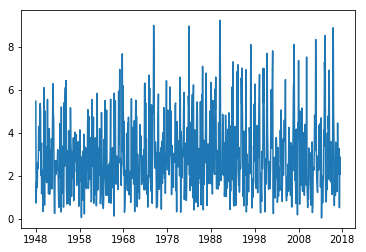

In [5]:
plt.plot(wind_df['t'],wind_df['speed'])

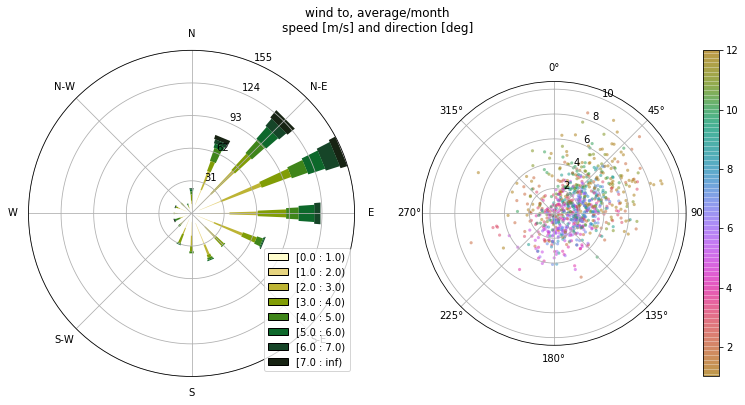

In [6]:
# create a wide figure, showing 2 wind roses with some extra info
fig = plt.figure(figsize=(13, 6))
# TODO: check from/to
# we're creating 2 windroses, one boxplot
# MVH-01082017 : debugging, included windrose projection instead of polar projection 
# MVH-01082017 : https://stackoverflow.com/a/42734053/2459096
ax = fig.add_subplot(1,2,1, projection="windrose")

# from radians 0 east, ccw to 0 north cw
wind_direction_deg = np.mod(90 - (360.0 * wind_df.direction / (2*np.pi)), 360)
# create a box plot
ax.box(wind_direction_deg, wind_df.speed, bins=np.arange(0, 8, 1), cmap=cmocean.cm.speed)
ax.legend(loc='lower right')

# and a scatter showing the seasonal pattern (colored by month)
ax = fig.add_subplot(1, 2, 2, 
    projection='polar',
    theta_direction=-1,
    theta_offset=np.pi/2.0
)
N = matplotlib.colors.Normalize(1, 12)
months = wind_df.t.apply(lambda x:x.month)
sc = ax.scatter(
    (np.pi/2)-wind_df.direction, 
    wind_df.speed, 
    c=months, 
    cmap=cmocean.cm.phase, 
    vmin=1, 
    vmax=12,
    alpha=0.5,
    s=10,
    edgecolor='none'
)
_ = plt.colorbar(sc, ax=ax)
_ = fig.suptitle('wind to, average/month\nspeed [m/s] and direction [deg]')

Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

http://www.psmsl.org/data/obtaining/rlr.php:

"In the past, the PSMSL also included the the Netherlands data in the above category of Metric records acceptable for time series work. These records are expressed relative to the national level system Normaal Amsterdamsch Peil (NAP). However, a recent re-levelling of NAP in 2005 introduced a small datum shift for the tide gauge time series. In order to maintain utility of these long records, we have reclassified most of the Netherlands records as RLR and introduced different RLR factors for the periods before and after 2005. While these records do not meet the strict definition of RLR and may still include prior re-levelling adjustments, we believe this represents the best path forward."

In [7]:
urls = {
    'metric_monthly': 'http://www.psmsl.org/data/obtaining/met.monthly.data/met_monthly.zip',
    'rlr_monthly': 'http://www.psmsl.org/data/obtaining/rlr.monthly.data/rlr_monthly.zip',
    'rlr_annual': 'http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip'
}
dataset_name = 'rlr_monthly'

In [8]:
url = 'http://www.psmsl.org/data/obtaining/rlr.diagrams/20.php'
iframe = '<iframe src=' + url + ' width=100% height=350></iframe>'
IPython.display.HTML(iframe)

In the website above the RLR Diagrom for Vlissingen is shown. It shows that the MSL (2007) level is 6.976 meters above RLR (2007), where the NAP 2005 - onwards level is 0.046m below the MSL (2007) level. This explains the `'rlr2nap': lambda x: x - (6976-46)` for Vlissingen in the code block below

In [ ]:
# these compute the rlr back to NAP (ignoring the undoing of the NAP correction)
main_stations = {
    1816: {
        'name': 'DAKAR 2', 
        'rlr2nap': lambda x: x - (0)
    },
    476: {
        'name': 'DAKAR', 
        'rlr2nap': lambda x:x - (0)
    }
}

In [39]:
# these compute the rlr back to NAP (ignoring the undoing of the NAP correction)
main_stations = {
    20: {
        'name': 'Vlissingen', 
        'rlr2nap': lambda x: x - (6976-46)
    },
    22: {
        'name': 'Hoek van Holland', 
        'rlr2nap': lambda x:x - (6994 - 121)
    },
    23: {
        'name': 'Den Helder', 
        'rlr2nap': lambda x: x - (6988-42)
    },
    24: {
        'name': 'Delfzijl', 
        'rlr2nap': lambda x: x - (6978-155)
    },
    25: {
        'name': 'Harlingen', 
        'rlr2nap': lambda x: x - (7036-122)
    },
    32: {
        'name': 'IJmuiden', 
        'rlr2nap': lambda x: x - (7033-83)
    },
    1551: {
        'name': 'Roompot buiten',
        'rlr2nap': lambda x: x - (7011-17)
    },
    9: {
        'name': 'Maassluis',
        'rlr2nap': lambda x: x - (6983-184)
    },
    236: {
        'name': 'West-Terschelling',
        'rlr2nap': lambda x: x - (7011-54)
    },
}

In [43]:
# # these compute the rlr back to NAP (ignoring the undoing of the NAP correction)
# main_stations = {
#     20: {
#         'name': 'Vlissingen', 
#         'rlr2nap': lambda x:x-0
#     },
#     22: {
#         'name': 'Hoek van Holland', 
#         'rlr2nap': lambda x:x-0
#     },
#     23: {
#         'name': 'Den Helder', 
#         'rlr2nap': lambda x:x-0
#     },
#     24: {
#         'name': 'Delfzijl', 
#         'rlr2nap': lambda x:x-0
#     },
#     25: {
#         'name': 'Harlingen', 
#         'rlr2nap': lambda x:x-0
#     },
#     32: {
#         'name': 'IJmuiden', 
#         'rlr2nap': lambda x:x-0
#     },
#     1551: {
#         'name': 'Roompot buiten',
#         'rlr2nap': lambda x:x-0
#     },
#     9: {
#         'name': 'Maassluis',
#         'rlr2nap': lambda x:x-0
#     },
#     236: {
#         'name': 'West-Terschelling',
#         'rlr2nap': lambda x:x-0
#     },
# }

In [44]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.keys())
main_stations_idx

[32, 20, 9, 22, 23, 24, 25, 236, 1551]

In [45]:
# download the zipfile
resp = requests.get(urls[dataset_name])

# we can read the zipfile
stream = io.BytesIO(resp.content)
zf = zipfile.ZipFile(stream)

# this list contains a table of 
# station ID, latitude, longitude, station name, coastline code, station code, and quality flag
csvtext = zf.read('{}/filelist.txt'.format(dataset_name))

stations = pandas.read_csv(
    io.BytesIO(csvtext), 
    sep=';',
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = stations.ix[main_stations_idx].copy()
# set the main stations, this should be a list of 6 stations
selected_stations

c:\python35\lib\site-packages\ipykernel\__main__.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,lat,lon,name,coastline_code,station_code,quality
id,,,,,,
32,52.462222,4.554722,IJMUIDEN,150,41,N
20,51.442222,3.596111,VLISSINGEN,150,101,N
9,51.917500,4.249722,MAASSLUIS,150,61,N
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N
23,52.964444,4.745000,DEN HELDER,150,31,N
24,53.326389,6.933056,DELFZIJL,150,1,N
25,53.175556,5.409444,HARLINGEN,150,21,N
236,53.363056,5.220000,WEST-TERSCHELLING,150,11,N
1551,51.619722,3.681944,ROOMPOT BUITEN,150,90,N


In [46]:
# show all the stations on a map

# compute the bounds of the plot
sw = (50, -5)
ne = (55, 10)
# transform to web mercator
sw_wm = pyproj.transform(WGS84, WEBMERCATOR, sw[1], sw[0])
ne_wm = pyproj.transform(WGS84, WEBMERCATOR, ne[1], ne[0])
# create a plot
fig = bokeh.plotting.figure(tools='pan, wheel_zoom', plot_width=600, plot_height=600, x_range=(sw_wm[0], ne_wm[0]), y_range=(sw_wm[1], ne_wm[1]))
fig.axis.visible = False
# add some background tiles
fig.add_tile(bokeh.tile_providers.STAMEN_TERRAIN)
# add the stations
x, y = pyproj.transform(WGS84, WEBMERCATOR, stations.lon.as_matrix(), stations.lat.as_matrix())
fig.circle(x, y)
x, y = pyproj.transform(WGS84, WEBMERCATOR, selected_stations.lon.as_matrix(), selected_stations.lat.as_matrix())
_ = fig.circle(x, y, color='red')

In [47]:
# show the plot
bokeh.io.show(fig)

Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

In [50]:
# each station has a number of files that you can look at.
# here we define a template for each filename

# stations that we are using for our computation
# define the name formats for the relevant files
names = {
    'datum': '{dataset}/RLR_info/{id}.txt',
    'diagram': '{dataset}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'data': '{dataset}/data/{id}.rlrdata',
    'doc': '{dataset}/docu/{id}.txt',
    'contact': '{dataset}/docu/{id}_auth.txt'
}

In [51]:
def get_url(station, dataset):
    """return the url of the station information (diagram and datum)"""
    info = dict(
        dataset=dataset,
        id=station.name
    )
    url = names['url'].format(**info)
    return url
# fill in the dataset parameter using the global dataset_name
f = functools.partial(get_url, dataset=dataset_name)
# compute the url for each station
selected_stations['url'] = selected_stations.apply(f, axis=1)
selected_stations

,lat,lon,name,coastline_code,station_code,quality,url
id,,,,,,,
32,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
9,51.917500,4.249722,MAASSLUIS,150,61,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
23,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
24,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
25,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
236,53.363056,5.220000,WEST-TERSCHELLING,150,11,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
1551,51.619722,3.681944,ROOMPOT BUITEN,150,90,N,http://www.psmsl.org/data/obtaining/rlr.diagra...


In [52]:
# selected_stations.ix[1816]['url']

In [53]:
def missing2nan(value, missing=-99999):
    """convert the value to nan if the float of value equals the missing value"""
    value = float(value)
    if value == missing:
        return np.nan
    return value

def year2date(year_fraction, dtype):
    startpoints = np.linspace(0, 1, num=12, endpoint=False)
    remainder = np.mod(year_fraction, 1)
    year = np.floor_divide(year_fraction, 1).astype('int')
    month = np.searchsorted(startpoints, remainder)
    dates = [
        datetime.datetime(year_i, month_i, 1) 
        for year_i, month_i 
        in zip(year, month)
    ]
    datetime64s = np.asarray(dates, dtype=dtype)
    return datetime64s

def get_data(station, dataset):
    """get data for the station (pandas record) from the dataset (url)"""
    info = dict(
        dataset=dataset,
        id=station.name
    )    
    bytes = zf.read(names['data'].format(**info))
    df = pandas.read_csv(
        io.BytesIO(bytes), 
        sep=';', 
        names=('year', 'height', 'interpolated', 'flags'),
        converters={
            "height": lambda x: main_stations[station.name]['rlr2nap'](missing2nan(x)),
            "interpolated": str.strip,
        }
    )
    df['station'] = station.name
    df['t'] = year2date(df.year, dtype=wind_df.t.dtype)
    # merge the wind and water levels
    merged = pandas.merge(df, wind_df, how='left', on='t')
    merged['u2'] = np.where(np.isnan(merged['u']), np.nanmean(merged['u']**2), merged['u']**2)
    merged['v2'] = np.where(np.isnan(merged['v']), np.nanmean(merged['v']**2), merged['v']**2)
    return merged

In [54]:
# get data for all stations
f = functools.partial(get_data, dataset=dataset_name)
# look up the data for each station
selected_stations['data'] = [f(station) for _, station in selected_stations.iterrows()]

In [55]:
selected_stations

,lat,lon,name,coastline_code,station_code,quality,url,data
id,,,,,,,,
32,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags s...
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags s...
9,51.917500,4.249722,MAASSLUIS,150,61,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags s...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags s...
23,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags s...
24,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags s...
25,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags s...
236,53.363056,5.220000,WEST-TERSCHELLING,150,11,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags s...
1551,51.619722,3.681944,ROOMPOT BUITEN,150,90,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags st...


Now that we have all data downloaded we can compute the mean.

In [56]:
# compute the mean
grouped = pandas.concat(selected_stations['data'].tolist())[['year', 't', 'height', 'u', 'v', 'u2', 'v2']].groupby(['year', 't'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890].copy()

In [57]:
# these are the mean waterlevels 
mean_df.tail()

,year,t,height,u,v,u2,v2
2023,2016.6250,2016-08-01,87.444444,2.327420,0.977419,5.416883,0.955348
2024,2016.7084,2016-09-01,118.888889,1.866666,2.026667,3.484444,4.107378
2025,2016.7916,2016-10-01,-7.222222,-0.818548,-0.975806,0.670021,0.952197
2026,2016.8750,2016-11-01,107.222222,1.303333,0.905000,1.698677,0.819025
2027,2016.9584,2016-12-01,119.444444,3.535484,2.718549,12.499649,7.390506


In [58]:
# selected_stations.to_pickle(r'D:\Projects\Pr\2695.40//selected_station_data.pkl')

In [59]:
# show all the stations, including the mean
title = 'Sea-surface height for Senegal tide gauges [{year_min} - {year_max}]'.format(
    year_min=mean_df.t.min().strftime('%Y-%m-%d'),
    year_max=mean_df.t.max().strftime('%Y-%m-%d') 
)
fig = bokeh.plotting.figure(title=title, x_range=(1860, 2020), plot_width=900, plot_height=400)
colors = bokeh.palettes.Spectral6
for color, (id_, station) in zip(colors, selected_stations.iterrows()):
    data = station['data']
    fig.circle(data.year, data.height, color=color, legend=station['name'], alpha=0.5, line_width=1)
fig.line(mean_df.year, mean_df.height, line_width=1, alpha=0.7, color='black', legend='Mean')
fig.legend.location = "bottom_right"
fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
fig.xaxis.axis_label = 'year'

In [60]:
bokeh.io.show(fig)

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that the selected epoch of 1970 is arbitrary. 
$
H(t) = a + b_{trend}(t-1970) + b_u\cos(2\pi\frac{t - 1970}{18.613}) + b_v\sin(2\pi\frac{t - 1970}{18.613}) + b_{wind_u^2}wind_u(t)^2 + b_{wind_v^2}wind_v(t)^2
$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$), Wind $U^2$ ($b_{wind_u^2}$) and  Wind $V^2$ ($b_{wind_v^2}$). 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise". 

$
H(t) = a + b_{trend}(t-1970) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t - 1970}{18.613}) + b_{v}\sin(2\pi\frac{t - 1970}{18.613})
$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. 

$
H(t) = a + b_{trend}(t-1970) + b_{quadratic}(t - 1970)*(t-1970) + b_{u}\cos(2\pi\frac{t - 1970}{18.613}) + b_{v}\sin(2\pi\frac{t - 1970}{18.613})
$


In [61]:
# define the statistical model
def linear_model(df, with_wind=True, with_season=True):
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind U^2', 'Wind V^2'])
    if with_season:
        for i in range(11):
            X = np.c_[
                X,
                np.logical_and(month >= i, month < i+1)
            ]
            names.append('month_%s' % (i+1, ))
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit()
    return fit, names

In [62]:
linear_with_wind_fit, names = linear_model(mean_df, with_wind=True, with_season=False)
print('Linear model with wind (1948-current)')
table = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names
)
IPython.display.display(table)
linear_fit, names = linear_model(mean_df, with_wind=False, with_season=False)
print('Linear model without wind (1890-current)')
table = linear_fit.summary(yname='Sea-surface height', xname=names)
IPython.display.display(table)

if (linear_fit.aic < linear_with_wind_fit.aic):
    print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
else:
    print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')

# things to check:
# Durbin Watson should be >1 for no worries, >2 for no autocorrelation
# JB should be non-significant for normal residuals
# abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful

Linear model with wind (1948-current)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     223.2
Date:                Fri, 18 Aug 2017   Prob (F-statistic):          9.14e-179
Time:                        20:21:32   Log-Likelihood:                -9086.6
No. Observations:                1524   AIC:                         1.819e+04
Df Residuals:                    1518   BIC:                         1.822e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -73.6227      3.906    -18.846      0.000     -81.285     -65.960
Trend          1.6968      0.066     25.639      0.000       1.567       1.827
Nodal U        7.4142      3.427      2.164      0.031       0.693      14.136
Nodal V       -8.8385      3.419     -2.585      0.010     -15.545      -2.132
Wind U^2       6.2900      0.325     19.346      0.000       5.652       6.928
Wind V^2       1.6929      0.472      3.584      0.000       0.766       2.619
==============================================================================
Omnibus:                      160.321   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              593.851
Skew:                          -0.468   Prob(JB):                    1.11e-129
Kurtosis:                       5.911   Cond. No.                         65.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear model without wind (1890-current)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     179.9
Date:                Fri, 18 Aug 2017   Prob (F-statistic):          8.17e-100
Time:                        20:21:32   Log-Likelihood:                -9275.0
No. Observations:                1524   AIC:                         1.856e+04
Df Residuals:                    1520   BIC:                         1.858e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -19.7755      2.996     -6.600      0.000     -25.653     -13.898
Trend          1.7366      0.075     23.218      0.000       1.590       1.883
Nodal U        7.6689      3.875      1.979      0.048       0.068      15.269
Nodal V       -9.0108      3.866     -2.331      0.020     -16.593      -1.428
==============================================================================
Omnibus:                       23.329   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.152
Skew:                           0.199   Prob(JB):                     2.84e-07
Kurtosis:                       3.563   Cond. No.                         57.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.


In [63]:
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
fig.circle(mean_df.year, mean_df.height, line_width=1, legend='Monthly mean sea level', color='black', alpha=0.5)
fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level, corrected for wind influence'
)
fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level', 
    color='green',
    alpha=0.5
)
fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
bokeh.io.show(fig)

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. 

In [64]:
p = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
colors = bokeh.palettes.Spectral9

for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station['data'].ix[station['data'].year >= 1890]
    fit, names = linear_fit, names = linear_model(df, with_wind=False, with_season=False)
    print(station['name'])
    smry = fit.summary(xname=names)
    #IPython.display.display(smry.tables[1])
    p.circle(station['data'].year, station['data'].height, alpha=0.1, color=color)
# loop again so we have the lines on top
for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station['data'].ix[station['data'].year >= 1890]
    fit, names = linear_fit, names = linear_model(df, with_wind=False, with_season=False)
    p.line(
        fit.model.exog[:, 1] + 1970, 
        fit.predict(), 
        line_width=3, 
        alpha=0.8,
        legend=station['name'],
        color=color
    )
bokeh.io.show(p)


c:\python35\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


IJMUIDEN
VLISSINGEN
MAASSLUIS
HOEK VAN HOLLAND
DEN HELDER
DELFZIJL
HARLINGEN
WEST-TERSCHELLING
ROOMPOT BUITEN


Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. 

In [65]:
from statsmodels.multivariate.pca import PCA

In [66]:
dfs = []
names = []
for color, (id, station) in zip(colors, selected_stations.iterrows()):
    df = station['data'].ix[station['data'].year >= 1930]
    dfs.append(df.set_index('year')['height'])
    names.append(station['name'])
merged = pandas.concat(dfs, axis=1)
merged.columns = names
diffs = merged.diff()

In [67]:
merged.head()

,IJMUIDEN,VLISSINGEN,MAASSLUIS,HOEK VAN HOLLAND,DEN HELDER,DELFZIJL,HARLINGEN,WEST-TERSCHELLING,ROOMPOT BUITEN
year,,,,,,,,,
1930.0416,-64.0,-128.0,35.0,-61.0,-17.0,13.0,57.0,33.0,NaN
1930.1250,-391.0,-355.0,-238.0,-336.0,-343.0,-336.0,-351.0,-363.0,NaN
1930.2084,-231.0,-224.0,-106.0,-190.0,-213.0,-159.0,-151.0,-201.0,NaN
1930.2916,-235.0,-206.0,-92.0,-166.0,-239.0,-218.0,-209.0,-260.0,NaN
1930.3750,-190.0,-185.0,-56.0,-126.0,-204.0,-136.0,-132.0,-195.0,NaN


In [68]:
merged.to_pickle(r'D:\Projects\Pr\2695.40//selected_station_data_1930.pkl')

In [69]:
diffs.to_pickle(r'D:\Projects\Pr\2695.40//selected_station_data_diffs.pkl')

In [70]:
X = diffs.as_matrix()[1:][:,:-1]
pca = statsmodels.multivariate.pca.PCA(X)
df = pandas.DataFrame(data=dict(year=merged.index[1:],  height=np.cumsum(pca.project(1)[:, 0])))
fit, names = linear_model(df, with_wind=False, with_season=False)
p = bokeh.plotting.figure()
p.circle(merged.index[1:], np.cumsum(pca.project(1)[:, 0]))
p.line(
        fit.model.exog[:, 1] + 1970, 
        fit.predict(), 
        line_width=3, 
        alpha=0.8,
        legend='First EOF',
        color=color
    )
IPython.display.display(fit.summary(xname=names))
bokeh.io.show(p)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     83.68
Date:                Fri, 18 Aug 2017   Prob (F-statistic):           1.70e-48
Time:                        20:22:02   Log-Likelihood:                -6347.3
No. Observations:                1043   AIC:                         1.270e+04
Df Residuals:                    1039   BIC:                         1.272e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      11.0206      3.344      3.296      0.001       4.459      17.582
Trend          2.0810      0.132     15.757      0.000       1.822       2.340
Nodal U        4.5595      4.636      0.983      0.326      -4.538      13.657
Nodal V      -10.1578      4.736     -2.145      0.032     -19.451      -0.865
==============================================================================
Omnibus:                       13.467   Durbin-Watson:                   1.335
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.485
Skew:                           0.179   Prob(JB):                     0.000263
Kurtosis:                       3.501   Cond. No.                         36.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [38]:
# define the statistical model
def broken_linear_model(df):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1993) * (df['year'] - 1993),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    X = sm.add_constant(X)
    model_broken_linear = sm.OLS(y, X)
    fit = model_broken_linear.fit()
    return fit
broken_linear_fit = broken_linear_model(mean_df)

In [39]:
# define the statistical model
def quadratic_model(df):
    """This model computes a parabolic linear fit. This corresponds to the hypothesis that sea-level is accelerating."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] - 1970) * (df['year'] - 1970),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    X = sm.add_constant(X)
    model_quadratic = sm.OLS(y, X)
    fit = model_quadratic.fit()
    return fit
quadratic_fit = quadratic_model(mean_df)

In [40]:
# summary of the broken linear model
broken_linear_fit.summary(yname='Sea-surface height', xname=['Constant', 'Trend', 'Trend(year > 1993)', 'Nodal U', 'Nodal V'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     135.3
Date:                Wed, 09 Aug 2017   Prob (F-statistic):           5.75e-99
Time:                        16:49:28   Log-Likelihood:                -9274.3
No. Observations:                1524   AIC:                         1.856e+04
Df Residuals:                    1519   BIC:                         1.859e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant             -22.6312      3.814     -5.934      0.000     -30.112     -15.151
Trend                  1.6667      0.094     17.641      0.000       1.481       1.852
Trend(year > 1993)     0.7530      0.622      1.210      0.226      -0.468       1.974
Nodal U                7.7323      3.875      1.996      0.046       0.132      15.332
Nodal V               -9.3925      3.878     -2.422      0.016     -16.999      -1.786
==============================================================================
Omnibus:                       24.212   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.912
Skew:                           0.209   Prob(JB):                     1.94e-07
Kurtosis:                       3.558   Cond. No.                         57.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# summary of the quadratic model
quadratic_fit.summary(yname='Sea-surface height', xname=['Constant', 'Trend', 'Trend**2', 'Nodal U', 'Nodal V'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     134.8
Date:                Wed, 09 Aug 2017   Prob (F-statistic):           1.19e-98
Time:                        16:49:30   Log-Likelihood:                -9275.0
No. Observations:                1524   AIC:                         1.856e+04
Df Residuals:                    1519   BIC:                         1.859e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -19.9295      3.860     -5.163      0.000     -27.501     -12.358
Trend          1.7413      0.106     16.430      0.000       1.533       1.949
Trend**2       0.0001      0.002      0.063      0.950      -0.004       0.005
Nodal U        7.6575      3.880      1.973      0.049       0.046      15.269
Nodal V       -9.0206      3.870     -2.331      0.020     -16.612      -1.430
==============================================================================
Omnibus:                       23.362   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.173
Skew:                           0.199   Prob(JB):                     2.81e-07
Kurtosis:                       3.562   Cond. No.                     3.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

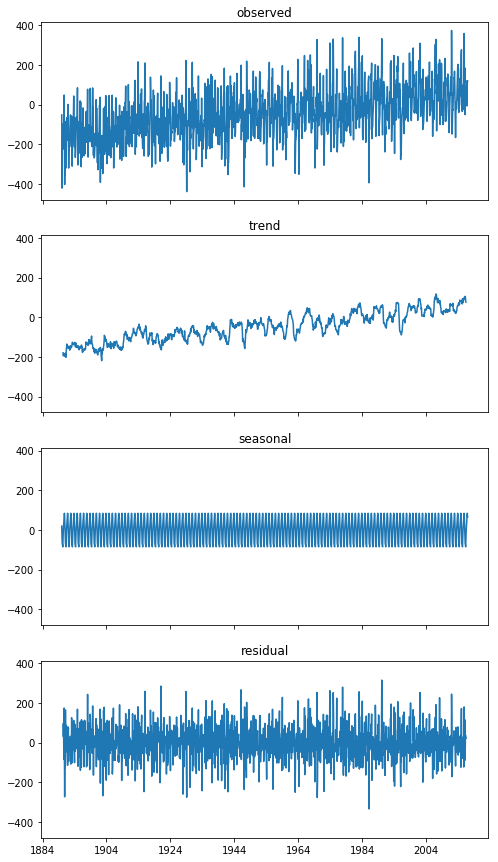

In [42]:
import statsmodels.tsa.seasonal
# mean_df.set_index(''))
n_year = 1
# 1 year moving average window used as filter 
filt = np.repeat(1./(12*n_year), 12*n_year)
seasonal_decompose_fit = statsmodels.tsa.seasonal.seasonal_decompose(mean_df.set_index('t')['height'], freq=12, filt=filt)
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(8, 15)) 
axes[0].plot(mean_df.t, seasonal_decompose_fit.observed)
axes[0].set_title('observed')
axes[1].plot(mean_df.t, seasonal_decompose_fit.trend)
axes[1].set_title('trend')
axes[2].plot(mean_df.t, seasonal_decompose_fit.seasonal)
axes[2].set_title('seasonal')
axes[3].plot(mean_df.t, seasonal_decompose_fit.resid)
axes[3].set_title('residual')



In [43]:
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
fig.circle(mean_df.year, mean_df.height, line_width=3, legend='Mean', color='black', alpha=0.5)
fig.line(mean_df.year, linear_fit.predict(), line_width=3, legend='Current')
fig.line(mean_df.year, broken_linear_fit.predict(), line_width=3, color='#33bb33', legend='Broken')
fig.line(mean_df.year, quadratic_fit.predict(), line_width=3, color='#3333bb', legend='Quadratic')

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
bokeh.io.show(fig)

c:\python35\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))


Conclusions
======
Below are some statements that depend on the output calculated above. 

In [44]:
msg = '''The current average waterlevel above NAP (in mm), 
based on the 6 main tide gauges for the year {year} is {height:.1f} cm.
The current sea-level rise is {rate:.0f} cm/century'''
print(msg.format(year=mean_df['year'].iloc[-1], height=linear_fit.predict()[-1]/10.0, rate=linear_fit.params.x1*100.0/10))

The current average waterlevel above NAP (in mm), 
based on the 6 main tide gauges for the year 2016.9584 is 0.4 cm.
The current sea-level rise is 27 cm/century


In [ ]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')

In [ ]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')